## **Practical No: 9**

## **AIM:** Financial Time Series Monte Carlo Simulation on S&P 500 stock data.

### **CODE and OUTPUT**

In [1]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install plotly==3.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.5 MB 1.7 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=cbe1b4563bdc523f0451a6de9da67307996ea6558141a033909c78d1e2896b27
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cufflinks 0.17.3 requires plotly>=4.1.1, but you have plotly 3.10.0 which is incompatible.


In [4]:
# Import Libraries
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from prophet import Prophet
# Statsmodels widely known for forecasting than Prophet
import statsmodels.api as sm
from scipy import stats
import pandas as pd
#from pandas import datetools
import datetime
from datetime import timedelta
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

# plt.style.available
plt.style.use("seaborn-whitegrid")

In [5]:
df = pd.read_csv('/content/all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [6]:
# Brief Description of our dataset
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [7]:
# Replace the column name from name to ticks
df = df.rename(columns={'Name': 'Ticks'})

In [8]:
# Let's analyze some of the stocks.
amzn = df.loc[df['Ticks'] == 'AMZN']
amzn.head()

,date,open,high,low,close,volume,Ticks
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


In [9]:
amzn.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Ticks   1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 78.7+ KB


In [10]:
#  Change to dateformat
amzn.head()

,date,open,high,low,close,volume,Ticks
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


In [11]:
# Create a copy to avoid the SettingWarning .loc issue 
amzn_df = amzn.copy()
# Change to datetime datatype.
amzn_df.loc[:, 'date'] = pd.to_datetime(amzn.loc[:,'date'], format="%Y/%m/%d")

In [12]:
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Ticks   1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 78.7+ KB


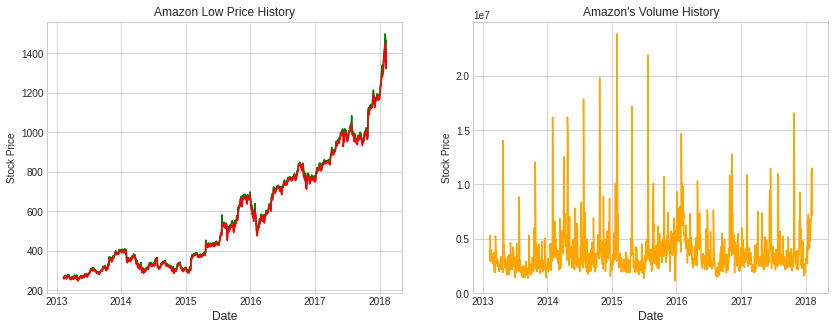

In [13]:
# Simple plotting of Amazon Stock Price
# First Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(amzn_df["date"], amzn_df["close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon Close Price History")

# Second Subplot
ax1.plot(amzn_df["date"], amzn_df["high"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon High Price History")

# Third Subplot
ax1.plot(amzn_df["date"], amzn_df["low"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon Low Price History")

# Fourth Subplot
ax2.plot(amzn_df["date"], amzn_df["volume"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Amazon's Volume History")
plt.show()

In [14]:
m = Prophet()

# Drop the columns
ph_df = amzn_df.drop(['open', 'high', 'low','volume', 'Ticks'], axis=1)
ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

ph_df.head()

,ds,y
46387,2013-02-08,261.95
46388,2013-02-11,257.21
46389,2013-02-12,258.70
46390,2013-02-13,269.47
46391,2013-02-14,269.24


In [15]:
m = Prophet()
m.fit(ph_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zuuqhwx/nzkeyne_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zuuqhwx/farlpzgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86152', 'data', 'file=/tmp/tmp8zuuqhwx/nzkeyne_.json', 'init=/tmp/tmp8zuuqhwx/farlpzgb.json', 'output', 'file=/tmp/tmp8zuuqhwx/prophet_modeloecveqp_/prophet_model-20221108172932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1619,2019-02-03,1760.281351,1374.046324,2170.710198
1620,2019-02-04,1736.816441,1341.780553,2168.612232
1621,2019-02-05,1736.480075,1344.127477,2164.334918
1622,2019-02-06,1736.051332,1341.287383,2172.385003
1623,2019-02-07,1735.289519,1335.335649,2175.966056


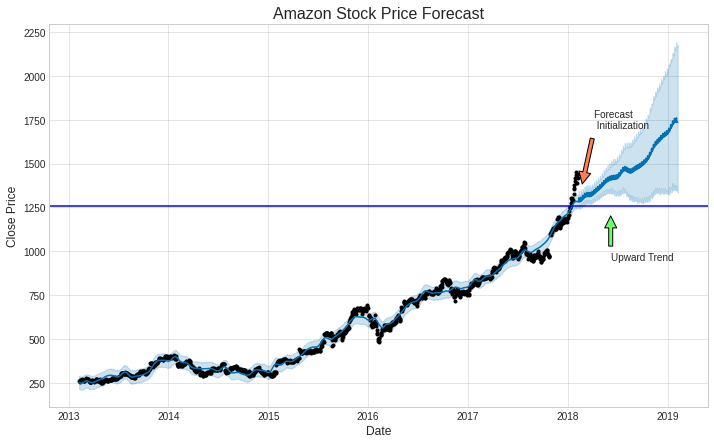

In [17]:
import matplotlib.dates as mdates

# Dates
starting_date = dt.datetime(2018, 4, 7)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2018, 6, 7)
trend_date1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2018, 2, 18)
pointing_arrow1 = mdates.date2num(pointing_arrow)

# Learn more Prophet tomorrow and plot the forecast for amazon.
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("Amazon Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

# Forecast initialization arrow
ax1.annotate('Forecast \n Initialization', xy=(pointing_arrow1, 1350), 
             xytext=(starting_date1,1700),
            arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
            )

# Trend emphasis arrow
ax1.annotate('Upward Trend', xy=(trend_date1, 1225), xytext=(trend_date1,950),
            arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
            )

ax1.axhline(y=1260, color='b', linestyle='-')

plt.show()

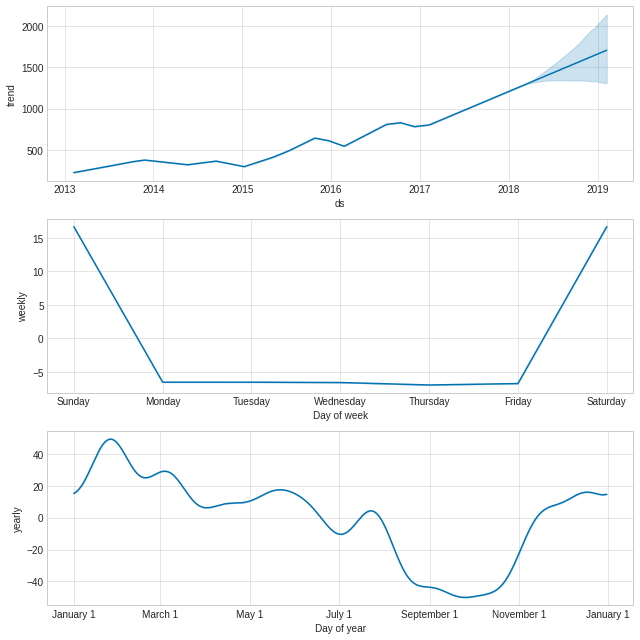

In [18]:
fig2 = m.plot_components(forecast)
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zuuqhwx/nztuymvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zuuqhwx/n_4x5hjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51976', 'data', 'file=/tmp/tmp8zuuqhwx/nztuymvc.json', 'init=/tmp/tmp8zuuqhwx/n_4x5hjj.json', 'output', 'file=/tmp/tmp8zuuqhwx/prophet_modelh9yjjl9p/prophet_model-20221108172935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


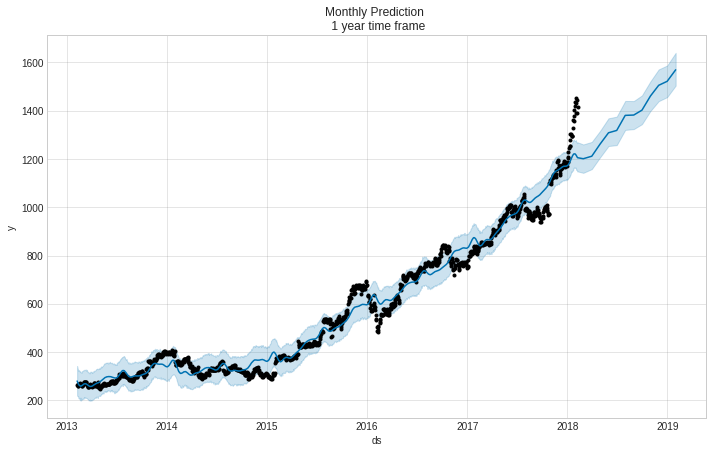

In [19]:
# Monthly Data Predictions
m = Prophet(changepoint_prior_scale=0.01).fit(ph_df)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title("Monthly Prediction \n 1 year time frame")

plt.show()

#### Trends:
<ul> 
<li>Amazon's stock price is showing signs of upper trend yearly. </li>
<li> Amazon's stock price show upper trend signs during January (December Sales tend to give a boost to Amazon's stock price)</li>
<li>There is no weekly trend for stock prices. </li>
</ul>

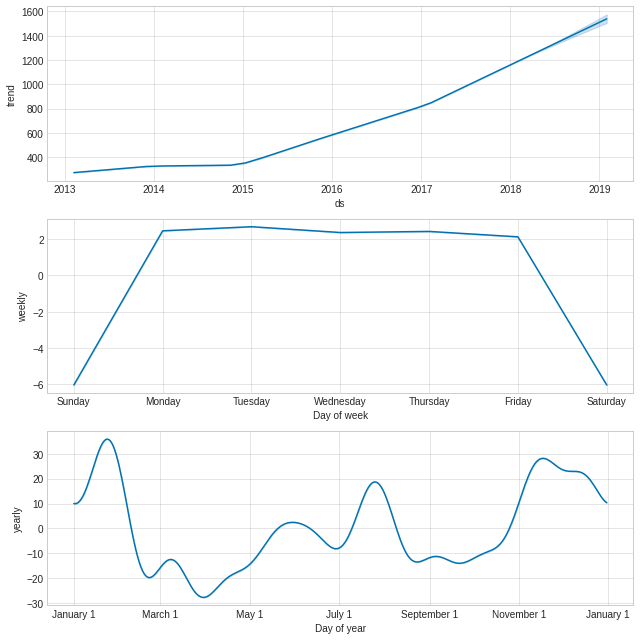

In [20]:
fig = m.plot_components(fcst)
plt.show()

In [21]:
amzn_df.head()

,date,open,high,low,close,volume,Ticks
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


In [22]:
# Moving Averages (10, 50 and 200)
amzn_df['10_d_avg'] = amzn_df.close.rolling(window=10).mean()
amzn_df['50_d_avg'] = amzn_df.close.rolling(window=50).mean()
amzn_df['200_d_avg'] = amzn_df.close.rolling(window=200).mean()
close_p = amzn_df['close'].values.tolist()

# Variables to insert into plotly
ten_d = amzn_df['10_d_avg'].values.tolist()
fifty_d = amzn_df['50_d_avg'].values.tolist()
twoh_d = amzn_df['200_d_avg'].values.tolist()
date = amzn_df['date'].values.tolist()

# Set date as index
amzn_df = amzn_df.set_index('date')

In [23]:
# American Airlines
aal_df = df.loc[df["Ticks"] == "AAL"]

aal_df.loc[:, 'date'] = pd.to_datetime(aal_df.loc[:,'date'], format="%Y/%m/%d")

aal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Ticks   1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 78.7+ KB


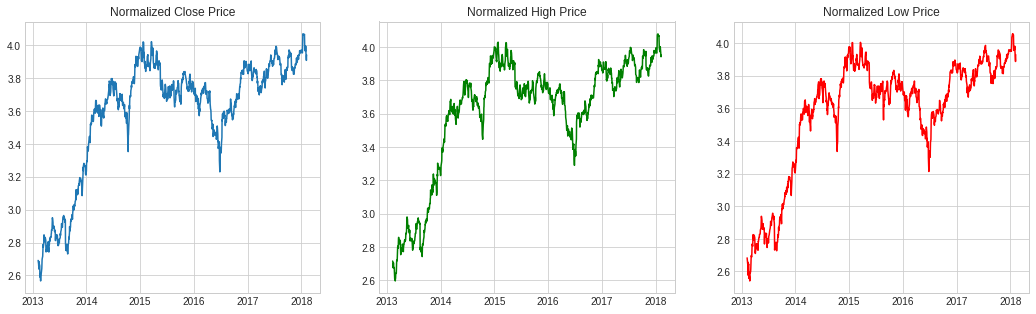

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

aal_df["close_log"] = np.log(aal_df["close"])
aal_df["high_log"] = np.log(aal_df["high"])
aal_df["low_log"] = np.log(aal_df["low"])

ax1.plot(aal_df["date"], aal_df["close_log"])
ax1.set_title("Normalized Close Price")
ax2.plot(aal_df["date"], aal_df["high_log"], color="g")
ax2.set_title("Normalized High Price")
ax3.plot(aal_df["date"], aal_df["low_log"], color="r")
ax3.set_title("Normalized Low Price")
plt.show()

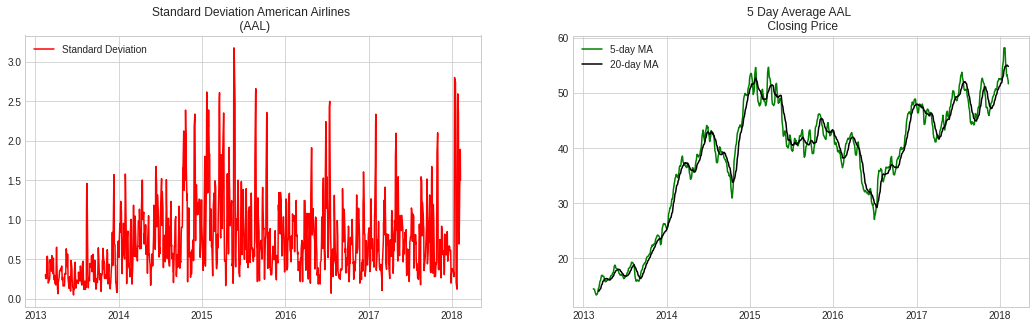

In [25]:
aal_df['std_close'] = aal_df["close"].rolling(5).std()
aal_df['mean_close'] = aal_df["close"].rolling(5).mean()
aal_df['twenty_mean_close'] = aal_df["close"].rolling(20).mean()

f, (std_ax, avg_ax) = plt.subplots(1, 2, figsize=(18,5))

std_ax.plot(aal_df["date"], aal_df["std_close"], color="r", label="Standard Deviation")
std_ax.legend(loc="upper left")
std_ax.set_title("Standard Deviation American Airlines \n (AAL)")

avg_ax.plot(aal_df["date"], aal_df["mean_close"], color="g", label="5-day MA")
avg_ax.plot(aal_df["date"], aal_df["twenty_mean_close"], color="k", label="20-day MA")
avg_ax.legend(loc="upper left")
avg_ax.set_title("5 Day Average AAL \n Closing Price")
plt.show()

In [26]:
m = Prophet()

# Drop the columns
ph_df = aal_df.drop(['open', 'high', 'low','volume', 'Ticks', 'close_log', 'high_log', 'mean_close', 'twenty_mean_close', 'low_log', 'std_close'], axis=1)
ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

ph_df.head()

,ds,y
0,2013-02-08,14.75
1,2013-02-11,14.46
2,2013-02-12,14.27
3,2013-02-13,14.66
4,2013-02-14,13.99


In [27]:
m.fit(ph_df)

future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zuuqhwx/5k6hudqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zuuqhwx/kig12spd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81847', 'data', 'file=/tmp/tmp8zuuqhwx/5k6hudqx.json', 'init=/tmp/tmp8zuuqhwx/kig12spd.json', 'output', 'file=/tmp/tmp8zuuqhwx/prophet_model15879g6f/prophet_model-20221108172938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1619,2019-02-03,64.308197,55.850222,71.989436
1620,2019-02-04,62.512951,53.826768,70.017504
1621,2019-02-05,62.505886,53.593387,70.238711
1622,2019-02-06,62.550212,53.859490,70.428215
1623,2019-02-07,62.530565,53.710336,70.117847


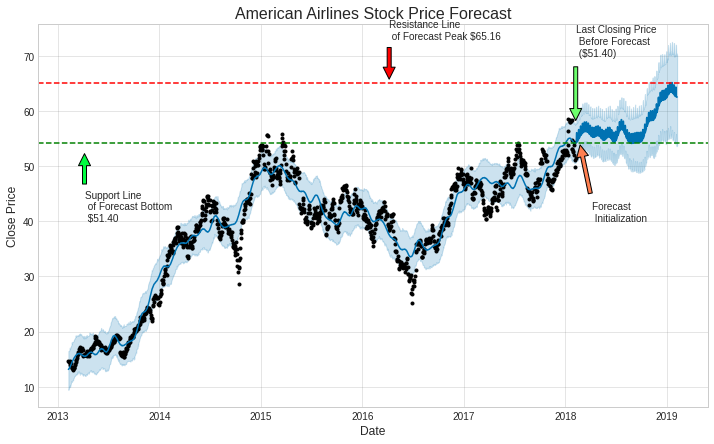

In [28]:
# Dates
starting_date = dt.datetime(2018, 4, 7)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2018, 2, 7)
trend_date1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2018, 2, 18)
pointing_arrow1 = mdates.date2num(pointing_arrow)

# Dates Forecasting Resistance Line
resistance_date = dt.datetime(2016, 4, 7)
resistance_date1 = mdates.date2num(resistance_date)

# Dates Forecasting Support Line
support_date = dt.datetime(2013, 4, 7)
support_date1 = mdates.date2num(support_date)

# Learn more Prophet tomorrow and plot the forecast for amazon.
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("American Airlines Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

# Forecast initialization arrow
ax1.annotate('Forecast \n Initialization', xy=(pointing_arrow1, 55), xytext=(starting_date1,40),
            arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
            )

# # Trend emphasis arrow
ax1.annotate('Last Closing Price \n Before Forecast \n ($51.40)', xy=(trend_date1, 57), xytext=(trend_date1,70),
            arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
            )

# Resistance Line
ax1.annotate('Resistance Line \n of Forecast Peak ${:.2f}'.format(forecast["yhat"].max()), xy=(resistance_date1, 65), xytext=(resistance_date1,73),
            arrowprops=dict(facecolor='#FF0000', shrink=0.1),
            )

# Support Line
ax1.annotate('Support Line \n of Forecast Bottom \n $51.40', xy=(support_date1, 53), xytext=(support_date1,40),
            arrowprops=dict(facecolor='#00FF40', shrink=0.1),
            )

ax1.axhline(y=65, color='r', linestyle='--')
ax1.axhline(y=54.2, color='g', linestyle='--')

plt.show()

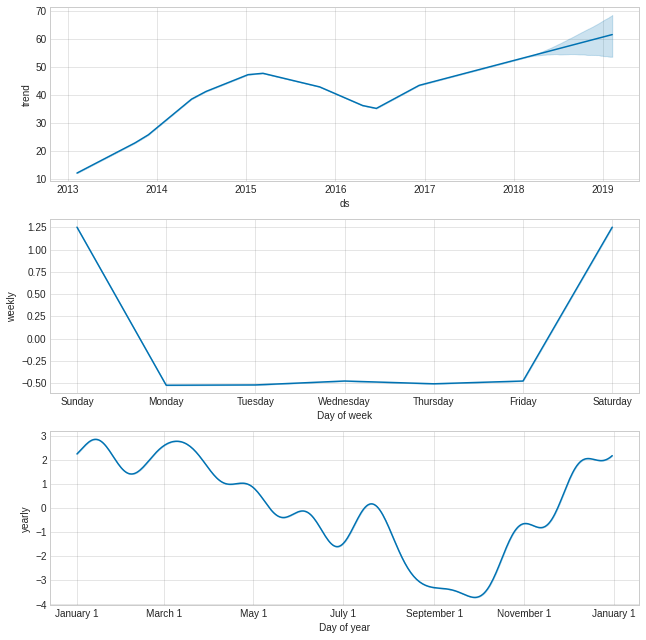

In [29]:
fig2 = m.plot_components(forecast)
plt.show()

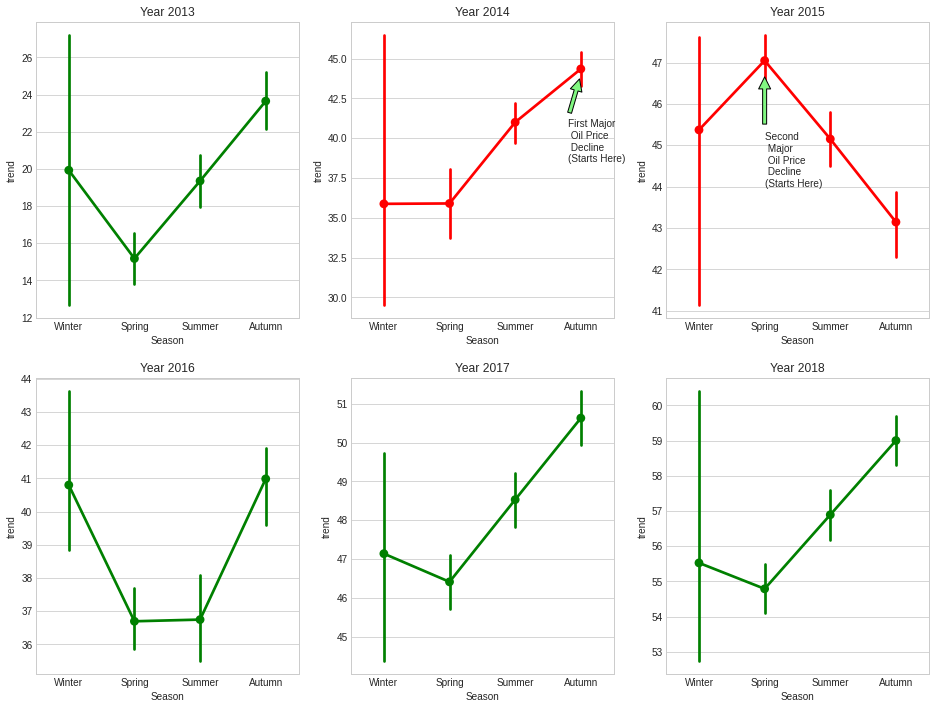

In [30]:
# Change dates from daily frequency to monthly frequency
forecast_monthly = forecast.resample('M', on='ds').mean()
forecast_monthly = forecast_monthly.reset_index() 

# Extract Year and Month and put it in a column.
forecast_monthly["month_int"] = forecast_monthly['ds'].dt.month
forecast_monthly["year"] = forecast_monthly['ds'].dt.year

forecast_monthly["month"] = np.nan
lst = [forecast_monthly]

for column in lst:
    column.loc[column["month_int"] == 1, "month"] = "January"
    column.loc[column["month_int"] == 2, "month"] = "February"
    column.loc[column["month_int"] == 3, "month"] = "March"
    column.loc[column["month_int"] == 4, "month"] = "April"
    column.loc[column["month_int"] == 5, "month"] = "May"
    column.loc[column["month_int"] == 6, "month"] = "June"
    column.loc[column["month_int"] == 7, "month"] = "July"
    column.loc[column["month_int"] == 8, "month"] = "August"
    column.loc[column["month_int"] == 9, "month"] = "September"
    column.loc[column["month_int"] == 10, "month"] = "October"
    column.loc[column["month_int"] == 11, "month"] = "November"
    column.loc[column["month_int"] == 12, "month"] = "December"
    
forecast_monthly['season'] = np.nan
lst2 = [forecast_monthly]

for column in lst2:
    column.loc[(column['month_int'] > 2) & (column['month_int'] <= 5), 'Season'] = 'Spring'
    column.loc[(column['month_int'] > 5) & (column['month_int'] <= 8), 'Season'] = 'Summer'
    column.loc[(column['month_int'] > 8) & (column['month_int'] <= 11), 'Season'] = 'Autumn'
    column.loc[column['month_int'] <= 2, 'Season'] = 'Winter'
    column.loc[column['month_int'] == 12, 'Season'] = 'Winter'
            
# Let's Create Seasonality Columns (Barplots that descripe the average trend per Season for each year)
# Create different axes by Year
df_2013 = forecast_monthly.loc[(forecast_monthly["year"] == 2013)]
df_2014 = forecast_monthly.loc[(forecast_monthly["year"] == 2014)]
df_2015 = forecast_monthly.loc[(forecast_monthly["year"] == 2015)]
df_2016 = forecast_monthly.loc[(forecast_monthly["year"] == 2016)]
df_2017 = forecast_monthly.loc[(forecast_monthly["year"] == 2017)]
df_2018 = forecast_monthly.loc[(forecast_monthly["year"] == 2018)]

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16,12))

# Year 2013
sns.pointplot(x="Season", y="trend",
                    data=df_2013, ax=ax1, color="g")

# Year 2014
sns.pointplot(x="Season", y="trend",
                    data=df_2014, ax=ax2, color="r")

# Year 2015
sns.pointplot(x="Season", y="trend",
                    data=df_2015, ax=ax3, color="r")

# Year 2016
sns.pointplot(x="Season", y="trend",
                    data=df_2016, ax=ax4, color="g")

# Year 2017
sns.pointplot(x="Season", y="trend",
                    data=df_2017, ax=ax5, color="g")

# Year 2018
sns.pointplot(x="Season", y="trend",
                    data=df_2018, ax=ax6, color="g")

ax1.set_title("Year 2013")
ax2.set_title("Year 2014")
ax3.set_title("Year 2015")
ax4.set_title("Year 2016")
ax5.set_title("Year 2017")
ax6.set_title("Year 2018")

# Oil dips
# September 2014 and June 2015
ax2.annotate('First Major \n Oil Price \n Decline \n(Starts Here)', xy=(3, 44), xytext=(2.8,38.5),
            arrowprops=dict(facecolor='#81F781', shrink=0.1),
            )

ax3.annotate('Second \n Major \n Oil Price \n Decline \n(Starts Here)', xy=(1, 46.8), xytext=(1,44),
            arrowprops=dict(facecolor='#81F781', shrink=0.1),
            )
plt.show()